<div style="background-color:#ff6666;
font-weight:bold;
font-size:5.2rem;
display:block;
width:80%;
padding:1.2em;
align:center;">

Module 3 Project


* Student name: Chris Lewis

* Student pace: part time

* Scheduled project review date/time: 

* Instructor name: James Irving

* Blog post URL: 

* Video of 5-min Non-Technical Presentation: 

<div style="background-color:#ffbf80;
font-weight:bold;
font-size:5.2rem;
display:block;
width:80%;
padding:1.2em;
align:center;">
Introduction


### Goal:

Data description
There are 3 types of input features:

Features:

**Objective** Features:
(Factual Information)
- Age | Objective Feature | **age** | int (days)
- Height | Objective Feature | **height** | int (cm) |
- Weight | Objective Feature | **weight** | float (kg) |
- Gender | Objective Feature | **gender** | categorical code |

**Examination** Features:
(Results of Medical Examination)
- Systolic blood pressure | Examination Feature | **ap_hi** | int |
- Diastolic blood pressure | Examination Feature | **ap_lo** | int |
- Cholesterol | Examination Feature | **cholesterol** | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | **gluc** | 1: normal, 2: above normal, 3: well above normal |

**Subjective** Features:
(Information given by the Patient)
- Smoking | Subjective Feature | **smoke** | binary |
- Alcohol intake | Subjective Feature | **alco** | binary |
- Physical activity | Subjective Feature | **active** | binary |

**Target**:

- Presence or absence of cardiovascular disease | Target Variable | **cardio** | binary |

All of the dataset values were collected at the moment of medical examination.


# Obtain

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report as cls_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import time

plt.style.use('seaborn-darkgrid')

In [242]:
# plt.style.available

In [243]:
df_raw = pd.read_csv('cvd.csv', sep=';', index_col='id')

# Inspect

In [244]:
df_raw.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [245]:
#Renaming columns ap_hi and ap_lo to systolic and diastolic, respectively
df_raw = df_raw.rename(columns={'ap_hi' : 'systolic', 'ap_lo': 'diastolic',
                                'cardio': 'cvd'}, inplace=False)

In [246]:
# Converting age from days to Years
df_raw['age'] = round(df_raw['age'] / 365, 2)

In [247]:
#Converting gender from (1,2) to (0,1) values
df_raw['gender'] = (df_raw['gender'] == 1).astype('int')

In [248]:
df_raw.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
0,50.39,0,168,62.0,110,80,1,1,0,0,1,0
1,55.42,1,156,85.0,140,90,3,1,0,0,1,1
2,51.66,1,165,64.0,130,70,3,1,0,0,0,1


In [249]:
# Looking for duplicated values
df_raw.duplicated().sum()

77

In [250]:
dup_df = df_raw[df_raw.duplicated(keep=False)]

In [251]:
# Inspecting the duplicated rows to make sure they are actually duplicates
dup_df.sort_values(by=['age']).head(6)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
45776,39.84,1,165,61.0,110,70,1,1,0,0,1,0
9092,39.84,1,165,61.0,110,70,1,1,0,0,1,0
57690,39.87,1,158,64.0,120,80,1,1,0,0,1,0
9004,39.87,1,158,64.0,120,80,1,1,0,0,1,0
59080,40.16,1,165,65.0,120,80,1,1,0,0,0,0
75547,40.16,1,165,65.0,120,80,1,1,0,0,0,0


In [252]:
#Dropping duplicates from dataframe
df_raw.drop_duplicates(inplace=True)
df_raw.duplicated().sum()

0

In [253]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69923 entries, 0 to 99999
Data columns (total 12 columns):
age            69923 non-null float64
gender         69923 non-null int32
height         69923 non-null int64
weight         69923 non-null float64
systolic       69923 non-null int64
diastolic      69923 non-null int64
cholesterol    69923 non-null int64
gluc           69923 non-null int64
smoke          69923 non-null int64
alco           69923 non-null int64
active         69923 non-null int64
cvd            69923 non-null int64
dtypes: float64(2), int32(1), int64(9)
memory usage: 6.7 MB


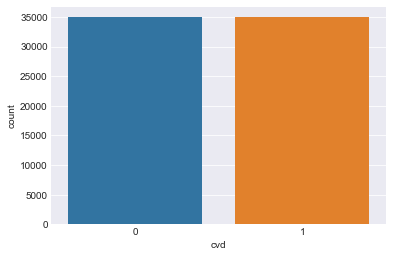

In [254]:
sns.countplot(x=df_raw['cvd'])

The data seems to have a well balanced number of subjects with and without a caridovascular disease

In [255]:
df_raw['cvd'].value_counts()

1    34964
0    34959
Name: cvd, dtype: int64

In [256]:
df_raw.isna().sum()

age            0
gender         0
height         0
weight         0
systolic       0
diastolic      0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cvd            0
dtype: int64

In [257]:
df_raw.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
count,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000
mean,53.339949,0.650258,164.359352,74.215656,128.826995,96.649157,1.367261,1.226707,0.088226,0.053831,0.803627,0.500036
std,6.760824,0.476892,8.213328,14.399850,154.095863,188.575412,0.680513,0.572536,0.283625,0.225685,0.397257,0.500004
min,29.580000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.390000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.430000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.970000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [258]:
# Height seems to be in centimeters and weight is in kilograms

In [259]:
# Converting height min/max values in centimeters to feet to get an idea of what
# I'm dealing with
height_min = ((df_raw['height'].describe()['min'] / 2.54) / 12).round(2)
height_max = ((df_raw['height'].describe()['max'] / 2.54) / 12).round(2)
print(f"min height: {height_min} ft\nmax height: {height_max} ft")


min height: 1.8 ft
max height: 8.2 ft


In [260]:
weight_min = df_raw['weight'].describe()['min'] * 2.205
weight_max = df_raw['weight'].describe()['max'] * 2.205
print(f"min weight: {weight_min} lbs\nmax weight: {weight_max} lbs")

min weight: 22.05 lbs
max weight: 441.0 lbs


#### There seem to be a lot of major outliers present in columns: 
- height
- weight
- ap_hi
- ap_lo

#### Creating a column for BMI

In [261]:
df_raw['bmi'] = df_raw['weight'] / (df_raw['height']/100)**2

#### Creating a column for Pulse Pressure

In [262]:
df_raw['pulse_pressure'] = df_raw['systolic'] - df_raw['diastolic']

In [263]:
df_raw.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
id,,,,,,,,,,,,,,
0,50.39,0,168,62.0,110,80,1,1,0,0,1,0,21.967120,30
1,55.42,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50
2,51.66,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60


In [264]:
def iqr_outliers(df, col, extreme=0):
    
    twenty_five = df[col].quantile(0.25)
    seventy_five = df[col].quantile(0.75)
    iqr = seventy_five - twenty_five
    if extreme == 0:
        lower = twenty_five - 1.5 * iqr
        upper = seventy_five + 1.5 * iqr
    else:
        lower = twenty_five - 3 * iqr
        upper = seventy_five + 3 * iqr
    return [lower, upper]
    
    

In [265]:
col_w_outliers = ['height', 'weight', 'systolic', 
                  'diastolic', 'bmi', 'pulse_pressure']
dashes = '----'
print("Lower and Upper Bounds for Extreme Outliers:")
print(f"{dashes*11}\n{dashes*11}")
for col in col_w_outliers:
    print(f"{col}: {iqr_outliers(df_raw, col, 0)}")
print(dashes*11)

Lower and Upper Bounds for Extreme Outliers:
--------------------------------------------
--------------------------------------------
height: [142.5, 186.5]
weight: [39.5, 107.5]
systolic: [90.0, 170.0]
diastolic: [65.0, 105.0]
bmi: [14.32686481387781, 39.788864734752174]
pulse_pressure: [25.0, 65.0]
--------------------------------------------


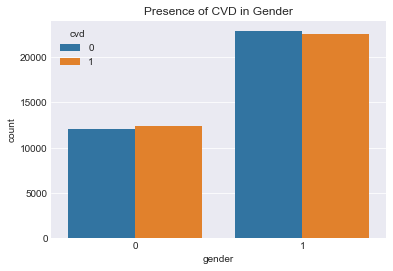

In [266]:
fig, ax = plt.subplots()
ax = sns.countplot(x='gender', hue='cvd', data=df_raw)
ax.set_title('Presence of CVD in Gender')
plt.show();

# Explore

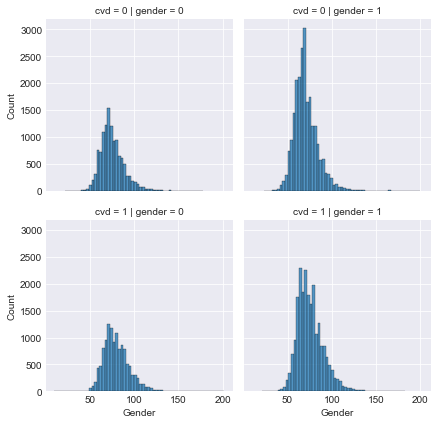

In [267]:
g = sns.FacetGrid(data=df_raw, col='gender', row='cvd', height=3)
g.map_dataframe(sns.histplot, 'weight', binwidth=3)
g.set_axis_labels('Gender', 'Count')
#g.title('Weight Distribution for Genders w/ and w/o CVD')

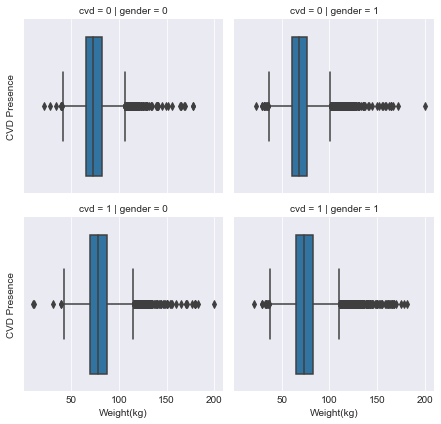

In [268]:
g = sns.FacetGrid(data=df_raw, col='gender', row='cvd', height=3)
g.map_dataframe(sns.boxplot, 'weight')
g.set_axis_labels('Weight(kg)','CVD Presence');

In [269]:
df_raw.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000
mean,53.339949,0.650258,164.359352,74.215656,128.826995,96.649157,1.367261,1.226707,0.088226,0.053831,0.803627,0.500036,27.560253,32.177838
std,6.760824,0.476892,8.213328,14.399850,154.095863,188.575412,0.680513,0.572536,0.283625,0.225685,0.397257,0.500004,6.093631,241.602390
min,29.580000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784,-10800.000000
25%,48.390000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,53.980000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,26.397977,40.000000
75%,58.430000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.240615,50.000000
max,64.970000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667,15940.000000


- systolic and diastolic pressures cannot be negative
- systolic pressure will always be greater in value than diastolic pressure, therefore we cannot have a negative pulse pressure
- maximum BP ever recorded was 370/360 (sys/dia) according to Narloch and Brandstater. (Referenced below)


In [270]:
(df_raw['systolic'] < 1).sum()

7

In [271]:
(df_raw['diastolic'] < 1).sum()

22

In [272]:
(df_raw['systolic'] < df_raw['diastolic']).sum()

1234

In [273]:
def diagnostics(df, col):
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 3, 1)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Histogram for {col}')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist='norm', plot=plt)
    plt.ylabel('Quantiles')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')
    
    plt.show()
    

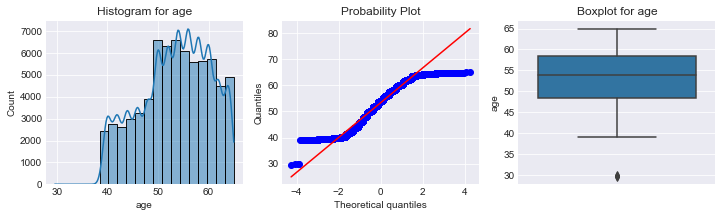

In [274]:
diagnostics(df_raw, 'age')

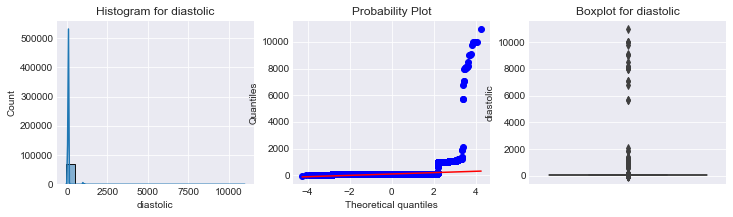

In [275]:
diagnostics(df_raw, 'diastolic')

## Test Area

In [228]:
test_df = df_raw.copy()

In [229]:
test_df.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000,69923.000000
mean,53.339949,0.650258,164.359352,74.215656,128.826995,96.649157,1.367261,1.226707,0.088226,0.053831,0.803627,0.500036,27.560253,32.177838
std,6.760824,0.476892,8.213328,14.399850,154.095863,188.575412,0.680513,0.572536,0.283625,0.225685,0.397257,0.500004,6.093631,241.602390
min,29.580000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784,-10800.000000
25%,48.390000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,53.980000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,26.397977,40.000000
75%,58.430000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.240615,50.000000
max,64.970000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667,15940.000000


In [230]:
# Removing negative and any Sys Pressure above 370
cut_df = test_df[(test_df['systolic'] >= 1) & (test_df['systolic'] <= 370)]
len(cut_df) / len(df_raw)

0.9993421334896958

In [231]:
# Removing negative and any Dia Pressure above 360
cut_df = cut_df[(cut_df['diastolic'] >= 1) & (cut_df['diastolic'] <= 360)]
len(cut_df) / len(df_raw)

0.9854840324356793

In [232]:
# Removing any cases where pulse pressure is <= 0
cut_df = cut_df[cut_df['pulse_pressure'] > 0]
len(cut_df) / len(df_raw)

0.9815368333738541

In [233]:
# We are going to target people with a height >= 147cm (4'10"(dwarfism))
# and <= 213cm (7'0" (gigantism))
cut_df = cut_df[(cut_df['height'] >= 147) & (cut_df['height'] <= 213)]
len(cut_df) / len(df_raw)

0.9720978790955765

In [234]:
# Target weight >= 36kg == 80lbs
cut_df = cut_df[cut_df['weight'] >= 36]
len(cut_df) / len(df_raw)

0.9719119602991863

In [235]:
cut_df.describe()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
count,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000,67959.000000
mean,53.309742,0.648744,164.616504,74.214258,126.664857,81.277991,1.364308,1.226004,0.088627,0.053650,0.803440,0.494548,27.416801,45.386866
std,6.761608,0.477366,7.629685,14.239993,16.689144,9.558294,0.678578,0.571910,0.284207,0.225327,0.397399,0.499974,5.162782,11.745162
min,29.580000,0.000000,147.000000,36.000000,16.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.520822,4.000000
25%,48.360000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,53.960000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.298488,40.000000
75%,58.410000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.110991,50.000000
max,64.970000,1.000000,207.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,68.308315,160.000000


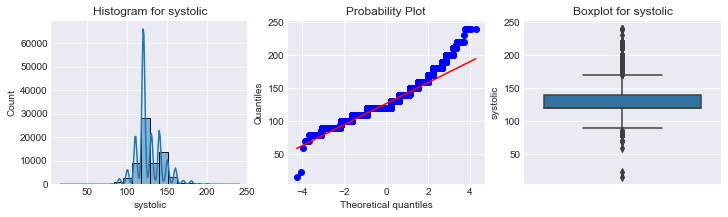

In [185]:
diagnostics(cut_df, 'systolic')

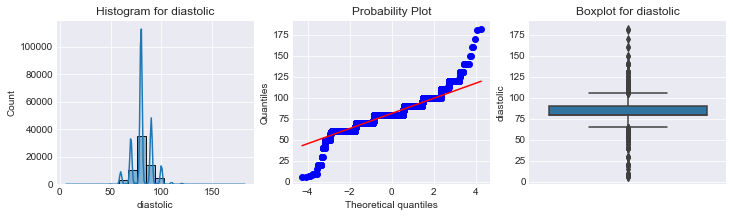

In [186]:
diagnostics(cut_df, 'diastolic')

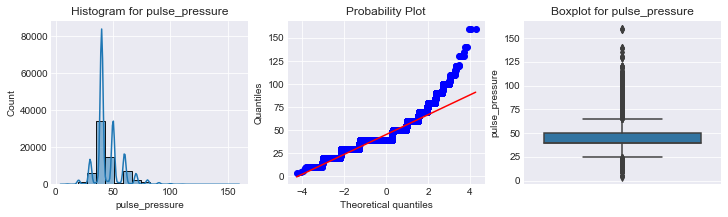

In [187]:
diagnostics(cut_df, 'pulse_pressure')

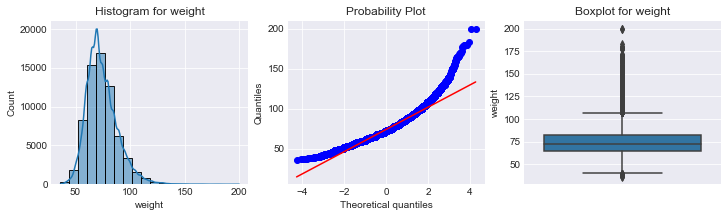

In [188]:
diagnostics(cut_df, 'weight')

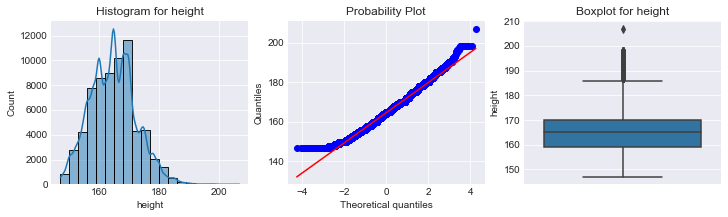

In [189]:
diagnostics(cut_df, 'height')

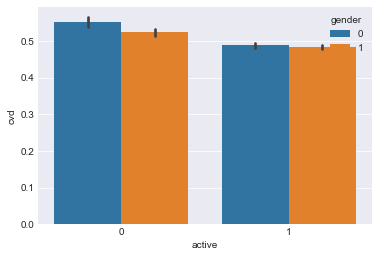

In [223]:
sns.barplot(x='active', data=cut_df, y='cvd', hue='gender')

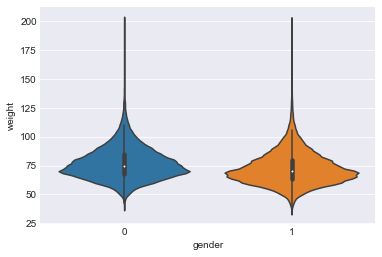

In [227]:
sns.violinplot(x='gender', y='weight', data=cut_df)

## End Test Area

## Train-Test Split

In [276]:
X = df_raw.drop('cvd', axis=1)
y = df_raw['cvd']

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    test_size=0.3)

In [278]:
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}")

X_train shape: (48946, 13)
X_test shape: (20977, 13)


In [279]:
def cut_out(df):
    # Removing negative and any Sys Pressure above 370
    cut_df = df[(df['systolic'] >= 1) & (df['systolic'] <= 370)]
    # Removing negative and any Dia Pressure above 360
    cut_df = cut_df[(cut_df['diastolic'] >= 1) & (cut_df['diastolic'] <= 360)]
    # Removing any cases where pulse pressure is <= 0
    cut_df = cut_df[cut_df['pulse_pressure'] > 0]
    # We are going to target people with a height >= 147cm (4'10"(dwarfism))
    # and <= 213cm (7'0" (gigantism))
    cut_df = cut_df[(cut_df['height'] >= 147) & (cut_df['height'] <= 213)]
    # Target weight >= 36kg == 80lbs
    cut_df = cut_df[cut_df['weight'] >= 36]
    print(len(cut_df) / len(df))
    return cut_df
    

# Pipelines

In [280]:
df_raw.columns

Index(['age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cvd', 'bmi',
       'pulse_pressure'],
      dtype='object')

In [281]:
set_config(display='diagram')

#### Creating Numerical Pipeline

In [282]:
num_cols = ['age', 'height', 'weight', 'systolic', 
            'diastolic', 'bmi', 'pulse_pressure']

In [283]:
num_tf_pipe = Pipeline(steps=[('scale', StandardScaler())])

In [284]:
num_tf_pipe

Pipeline(steps=[('scale', StandardScaler())])

####  Creating Categorical Pipeline

In [285]:
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [286]:
cat_tf_pipe = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, 
                                      handle_unknown='ignore'))])

In [287]:
cat_tf_pipe

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Combining Pipelines

In [288]:
preprocess = ColumnTransformer(transformers=[('num', num_tf_pipe, num_cols),
                                            ('cat', cat_tf_pipe, cat_cols)])
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['age', 'height', 'weight', 'systolic',
                                  'diastolic', 'bmi', 'pulse_pressure']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['gender', 'cholesterol', 'gluc', 'smoke',
                                  'alco', 'active'])])

In [289]:
X_train_tf = preprocess.fit_transform(X_train)
X_test_tf = preprocess.transform(X_test)

In [290]:
X_train_tf

array([[-0.49721538, -0.53856155,  0.05396913, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.37309285, -0.41622345, -1.2623536 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.01001711,  1.05183365,  1.37029185, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.34982841, -0.53856155, -0.63883231, ...,  1.        ,
         0.        ,  1.        ],
       [-0.50313876,  0.3178051 , -0.29243159, ...,  0.        ,
         1.        ,  0.        ],
       [-1.78258953, -0.90557582, -1.40091389, ...,  0.        ,
         0.        ,  1.        ]])

Finding Feature Names

In [291]:
preprocess.named_transformers_

{'num': Pipeline(steps=[('scale', StandardScaler())]),
 'cat': Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])}

In [292]:
preprocess.named_transformers_['cat'].named_steps

{'ohe': OneHotEncoder(handle_unknown='ignore', sparse=False)}

In [293]:
cat_feat_names = preprocess.named_transformers_['cat'].\
                 named_steps['ohe'].get_feature_names(cat_cols).tolist()

In [294]:
feature_cols = num_cols + cat_feat_names
feature_cols

['age',
 'height',
 'weight',
 'systolic',
 'diastolic',
 'bmi',
 'pulse_pressure',
 'gender_0',
 'gender_1',
 'cholesterol_1',
 'cholesterol_2',
 'cholesterol_3',
 'gluc_1',
 'gluc_2',
 'gluc_3',
 'smoke_0',
 'smoke_1',
 'alco_0',
 'alco_1',
 'active_0',
 'active_1']

In [295]:
X_train_df = pd.DataFrame(X_train_tf, columns=feature_cols)
X_test_df = pd.DataFrame(X_test_tf, columns=feature_cols)

In [296]:
X_train_df.describe()

,age,height,weight,systolic,diastolic,bmi,pulse_pressure,gender_0,gender_1,cholesterol_1,...,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
count,4.894600e+04,4.894600e+04,4.894600e+04,4.894600e+04,4.894600e+04,4.894600e+04,4.894600e+04,48946.000000,48946.000000,48946.000000,...,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000,48946.000000
mean,1.229579e-15,-1.059151e-15,-2.026555e-16,-2.859823e-17,-1.742024e-17,-3.027493e-16,1.843643e-17,0.350897,0.649103,0.747068,...,0.115985,0.849446,0.074470,0.076084,0.910902,0.089098,0.946104,0.053896,0.195440,0.804560
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.477256,0.477256,0.434697,...,0.320210,0.357617,0.262537,0.265135,0.284888,0.284888,0.225815,0.225815,0.396543,0.396543
min,-3.518141e+00,-1.289471e+01,-4.449240e+00,-1.524544e+00,-5.531293e-01,-4.002076e+00,-4.324986e+01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.326699e-01,-6.608996e-01,-6.388323e-01,-5.231016e-02,-9.123047e-02,-6.141174e-01,2.478126e-02,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,9.660378e-02,7.312892e-02,-1.538713e-01,-5.231016e-02,-9.123047e-02,-1.910233e-01,2.478126e-02,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,7.526185e-01,6.848194e-01,5.389301e-01,5.674422e-02,-3.349311e-02,4.330743e-01,6.470252e-02,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.722572e+00,1.047187e+01,8.713987e+00,8.664592e+01,6.295796e+01,4.546952e+01,6.349958e+01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling

### KNearest Neighbors Pipeline

In [297]:
knn_pipe = Pipeline(steps=[('preprocessing', preprocess), ('knn', KNeighborsClassifier())])

In [298]:
knn_pipe.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scale', StandardScaler())]),
                                  ['age', 'height', 'weight', 'systolic',
                                   'diastolic', 'bmi', 'pulse_pressure']),
                                 ('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['gender', 'cholesterol', 'gluc', 'smoke',
                                   'alco', 'active'])]),
 'knn': KNeighborsClassifier()}

In [299]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'height', 'weight',
                                                   'systolic', 'diastolic',
                                                   'bmi', 'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active'])])),
                ('knn', KNeighborsClassifier())])

In [300]:
y_pred_test = knn_pipe.predict(X_test)

In [301]:
print(cls_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64     10451
           1       0.64      0.62      0.63     10526

    accuracy                           0.64     20977
   macro avg       0.64      0.64      0.64     20977
weighted avg       0.64      0.64      0.64     20977



#### GridSearch w/ KNN Pipeline

In [302]:
param_grid = {'knn__n_neighbors': list(range(1, 10, 2)), 
              'knn__metric':['euclidean', 'minkowski', 'manhattan']}

In [303]:
grid = GridSearchCV(knn_pipe, param_grid=param_grid,scoring='f1')
grid.fit(X_train, y_train)
grid.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 9}

### XGBoost Pipeline

In [308]:
xgb_pipe = Pipeline(steps=[('preprocessing', preprocess), ('xgb', xgb.XGBClassifier())])

In [309]:
xgb_pipe.named_steps

{'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scale', StandardScaler())]),
                                  ['age', 'height', 'weight', 'systolic',
                                   'diastolic', 'bmi', 'pulse_pressure']),
                                 ('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  ['gender', 'cholesterol', 'gluc', 'smoke',
                                   'alco', 'active'])]),
 'xgb': XGBClassifier()}

In [310]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'height', 'weight',
                                                   'systolic', 'diastolic',
                                                   'bmi', 'pulse_pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active'])])),
                ('xgb', XGBClassifier())])

In [311]:
y_pred_test = xgb_pipe.predict(X_test)

In [312]:
print(cls_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10451
           1       0.76      0.69      0.72     10526

    accuracy                           0.74     20977
   macro avg       0.74      0.74      0.74     20977
weighted avg       0.74      0.74      0.74     20977



In [324]:
param_grid = {'xgb__learning_rate': [0.001, 0.01, 0.1], 
              'xgb__max_depth': [3, 4, 5, 6]}

In [325]:
start = time.time()

grid = GridSearchCV(xgb_pipe, param_grid=param_grid,scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)

finish = time.time()
print(f"Total time to run program: {np.round(finish - start, 2)} seconds")

{'xgb__learning_rate': 0.001, 'xgb__max_depth': 4}
Total time to run program: 220.09 seconds


#### function from class

In [218]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Reds',label=''):
    
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "             [i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes, dashes, sep='\n')
    print('\n\n')
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report #fig,axes

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.71      0.71     10372
           1       0.70      0.68      0.69     10016

    accuracy                           0.70     20388
   macro avg       0.70      0.70      0.70     20388
weighted avg       0.70      0.70      0.70     20388

------------------------------------------------------------
------------------------------------------------------------





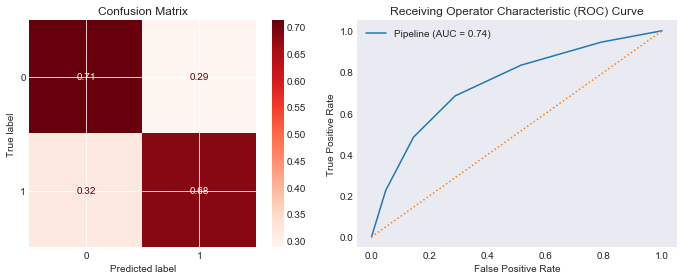

{'0': {'precision': 0.7001800435895006,
  'recall': 0.7123987659082144,
  'f1-score': 0.7062365591397849,
  'support': 10372},
 '1': {'precision': 0.6966954753431622,
  'recall': 0.6841054313099042,
  'f1-score': 0.6903430557654526,
  'support': 10016},
 'accuracy': 0.6984991171277222,
 'macro avg': {'precision': 0.6984377594663314,
  'recall': 0.6982520986090592,
  'f1-score': 0.6982898074526187,
  'support': 20388},
 'weighted avg': {'precision': 0.6984681819279681,
  'recall': 0.6984991171277222,
  'f1-score': 0.6984285676841584,
  'support': 20388}}

In [219]:
evaluate_classification(knn_pipe, X_test, y_test)

------------------------------------------------------------
------------------------------------------------------------
             [i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     10372
           1       0.72      0.69      0.70     10016

    accuracy                           0.71     20388
   macro avg       0.71      0.71      0.71     20388
weighted avg       0.71      0.71      0.71     20388

------------------------------------------------------------
------------------------------------------------------------





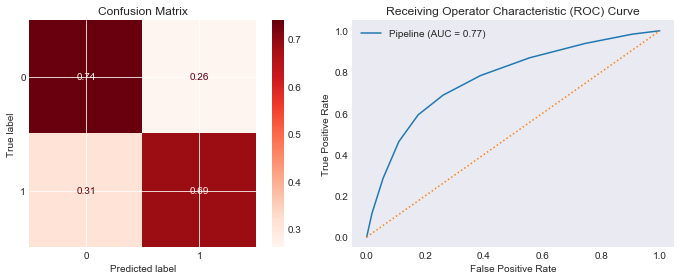

{'0': {'precision': 0.7103556872915895,
  'recall': 0.7393945237177015,
  'f1-score': 0.7245842781557067,
  'support': 10372},
 '1': {'precision': 0.7182026688907422,
  'recall': 0.6877995207667732,
  'f1-score': 0.702672378620971,
  'support': 10016},
 'accuracy': 0.7140474789091622,
 'macro avg': {'precision': 0.7142791780911659,
  'recall': 0.7135970222422374,
  'f1-score': 0.7136283283883389,
  'support': 20388},
 'weighted avg': {'precision': 0.7142106690307063,
  'recall': 0.7140474789091622,
  'f1-score': 0.7138196329850223,
  'support': 20388}}

In [220]:
evaluate_classification(grid.best_estimator_, X_test, y_test)

# Citations

1. Narloch, J A, and M E Brandstater. *“Influence of breathing technique on arterial blood pressure during heavy weight lifting.”* Archives of physical medicine and rehabilitation vol. 76,5 (1995): 457-62.

2. Yildiran, Tansel et al. *“Low pulse pressure as a predictor of death in patients with mild to advanced heart failure.”* Texas Heart Institute journal vol. 37,3 (2010): 284-90.

3. *“Excess Growth Hormone Increases Risk of Heart Disease, Diabetes.”* NIH Record, nihrecord.nih.gov/2018/01/26/excess-growth-hormone-increases-risk-heart-disease-diabetes#:%7E:text=Excess%20Growth%20Hormone%20Increases%20Risk%20of%20Heart%20Disease%2C%20Diabetes,-By%20Eric%20Bock&text=Diseases%20of%20excess%20growth%20hormone,Rounds%20lecture%20in%20Lipsett%20Amphitheater. 
Accessed 11 Sept. 2020.

4. Burger, Albert G et al. *“Cardiovascular risk in patients with growth hormone deficiency: effects of growth hormone substitution.”* Endocrine practice : official journal of the American College of Endocrinology and the American Association of Clinical Endocrinologists vol. 12,6 (2006): 682-9.